In [50]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps
from vecopsciml.operators import zero_order as zo
from vecopsciml.algebra import zero_order as azo

# Imports de las funciones creadas para este programa
from models.fft_model import FFTNeuralNetwork
from utils.folders import create_folder
from utils.load_data import load_data
from utils.checkpoints import load_results
from trainers.train import train_loop

In [51]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data\non_linear\non_linear.pkl')
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results\non_linear')
MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results\non_linear\model_fft')

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_PATH)

Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\non_linear
Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\non_linear\model_fft


In [52]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data\non_linear\non_linear.pkl


In [53]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


In [55]:
def get_modes_base_and_coeficients(data, n_modes):

    # FFT decomposition and obtain energy of each mode
    fft_data = torch.fft.fft2(data)
    fft_data_shifted = torch.fft.fftshift(fft_data)
    energy = torch.abs(fft_data_shifted)
    energy_flattened = energy.flatten(1, 2)

    # Get the n_modes more energetic modes and their indices
    top_energetic = torch.topk(energy_flattened, n_modes).indices
    top_energetic_indices, _ = zip(*Counter(top_energetic.flatten()).most_common(n_modes))

    # Get base and coefficients
    modes_base = list(map(int, top_energetic_indices))
    coeficients = fft_data_shifted.flatten(1, 2)[:, top_energetic_indices]

    return coeficients, modes_base


def reconstruct_data_fft(coeficients, base, data_shape):

    # Create the new tensor to allocate filtered modes
    filtered_modes = torch.zeros((coeficients.shape[0], data_shape[1]*data_shape[2]), dtype=torch.complex64)
    filtered_modes[:, base] = coeficients

    # Reshape filtered modes and reconstruct image
    filtered_modes_base_fft_shifted =  filtered_modes.reshape(data_shape)
    filtered_modes_base = torch.fft.ifftshift(filtered_modes_base_fft_shifted)

    reconstructed_data = torch.real(torch.fft.ifft2(filtered_modes_base)) 

    return reconstructed_data

In [56]:
n_modes = 19

u_original = torch.Tensor(dataset['y_train'])
u_coeficients, u_modes_base = get_modes_base_and_coeficients(u_original, n_modes)
u_reconstructed = reconstruct_data_fft(u_coeficients, u_modes_base, u_original.shape)

real_part = u_coeficients.real
imag_part = u_coeficients.imag

y_train = torch.stack([real_part, imag_part], dim=-1)

In [57]:
X_train = torch.Tensor(dataset['X_train']).unsqueeze(1)
K_train = torch.tensor(dataset['k_train'], dtype=torch.float32, requires_grad=True)
f_train = torch.tensor(dataset['f_train'], dtype=torch.float32, requires_grad=True)

input_size = X_train[0].shape
predictive_output_size = y_train[0].shape
explanatory_output_size = K_train[0].shape

In [58]:
def reconstruct_data_fft_NN(coeficients, base, data_shape):

    # Create the new tensor to allocate filtered modes
    filtered_modes = torch.zeros((coeficients.shape[0], data_shape[0]*data_shape[1]), dtype=torch.complex64)
    filtered_modes[:, base] = coeficients

    # Reshape filtered modes and reconstruct image
    filtered_modes_base_fft_shifted =  filtered_modes.reshape((coeficients.shape[0], *data_shape))
    filtered_modes_base = torch.fft.ifftshift(filtered_modes_base_fft_shifted)

    reconstructed_data = torch.real(torch.fft.ifft2(filtered_modes_base)) 

    return reconstructed_data

In [59]:
u_original = torch.Tensor(dataset['y_train'])
u_coeficients, u_modes_base = get_modes_base_and_coeficients(u_original, n_modes)
u_reconstructed = reconstruct_data_fft(u_coeficients, u_modes_base, u_original.shape)

real_part = u_coeficients.real
imag_part = u_coeficients.imag

y_train = torch.stack([real_part, imag_part], dim=-1)

In [60]:
# u_original = torch.Tensor(dataset['y_val'])
# u_coeficients, u_modes_base = get_modes_base_and_coeficients(u_original, n_modes)
# u_reconstructed = reconstruct_data_fft(u_coeficients, u_modes_base, u_original.shape)

# real_part = u_coeficients.real
# imag_part = u_coeficients.imag

# y_val = torch.stack([real_part, imag_part], dim=-1)

In [61]:


X_val = torch.Tensor(dataset['X_val']).unsqueeze(1)
y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
f_val = TensOps(torch.tensor(dataset['f_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)



In [62]:
import torch
import torch.nn as nn

from vecopsciml.utils import TensOps
from vecopsciml.operators.zero_order import Mx, My

class FFTNeuralNetwork(nn.Module):

    def __init__(self, input_size, predictive_output_size, explanatory_output_size, modes_base, **kwargs):
        super(FFTNeuralNetwork, self).__init__()

        self.input = input_size
        self.output_pred = predictive_output_size
        self.output_expl = explanatory_output_size

        self.hidden_units_pred = 10
        self.hidden_units_exp = 15
        self.filters_exp = 10

        self.modes_base = modes_base

        # Predictive network
        self.flatten_layer_pred = nn.Flatten(start_dim=1, end_dim=-1)
        self.hidden1_layer_pred = nn.Linear(torch.prod(torch.tensor(self.input)), self.hidden_units_pred)  
        self.hidden2_layer_pred = nn.Linear(self.hidden_units_pred, self.hidden_units_pred)  
        self.output_layer_pred = nn.Linear(self.hidden_units_pred, self.output_pred[0]*self.output_pred[1])

        # Explanatory network
        self.conv1_exp = nn.Conv2d(in_channels=1, out_channels=self.filters_exp, kernel_size=1)
        self.flatten_layer_exp = nn.Flatten()
        self.hidden1_layer_exp = nn.LazyLinear(self.hidden_units_exp)
        self.hidden2_layer_exp = nn.Linear(self.hidden_units_exp, self.hidden_units_exp)
        self.output_layer_exp = nn.Linear(self.hidden_units_exp, self.filters_exp * (self.output_expl[0] - 1) * (self.output_expl[1] - 1))
        self.conv2_exp = nn.Conv2d(in_channels=self.filters_exp, out_channels=1, kernel_size=1)


    def forward(self, X):

        # Predictive network
        X = self.flatten_layer_pred(X)
        X = torch.sigmoid(self.hidden1_layer_pred(X))
        X = torch.sigmoid(self.hidden2_layer_pred(X))
        output_predictive_net = self.output_layer_pred(X)

        # Obtain real and imaginary part of output and transform it in a complex number
        output_predictive = output_predictive_net.view(output_predictive_net.size(0), self.output_pred[0], self.output_pred[1])
        real = output_predictive[..., 0]
        imag = output_predictive[..., 1]
        predicted_coef = torch.complex(real, imag)
        
        # Reconstruction of u(x, y) with iFFT
        u_pred = reconstruct_data_fft_NN(predicted_coef, self.modes_base, self.output_expl).unsqueeze(1)
        um_pred = Mx(My(TensOps(u_pred, space_dimension=2, contravariance=0, covariance=0))).values

        # Explanatory network
        x = torch.sigmoid(self.conv1_exp(um_pred))
        x = self.flatten_layer_exp(x)
        x = torch.sigmoid(self.hidden1_layer_exp(x))
        x = torch.sigmoid(self.hidden2_layer_exp(x))
        x = self.output_layer_exp(x)
        x = x.view(x.size(0), self.filters_exp, self.output_expl[0] - 1, self.output_expl[1] - 1)
        K_pred = self.conv2_exp(x)

        return output_predictive, u_pred, K_pred

In [63]:
# Se carga el modelo y el optimizador
model = FFTNeuralNetwork(input_size, predictive_output_size, explanatory_output_size, modes_base=u_modes_base)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=torch.device('cpu'))

In [64]:
train_total_loss_list = lists['train_total_loss_list']
train_e_loss_list = lists['train_e_loss_list']
train_pi1_loss_list = lists['train_pi1_loss_list']
train_pi2_loss_list = lists['train_pi2_loss_list']
train_pi3_loss_list = lists['train_pi3_loss_list']

test_total_loss_list = lists['test_total_loss_list']
test_e_loss_list = lists['test_e_loss_list']
test_pi1_loss_list = lists['test_pi1_loss_list']
test_pi2_loss_list = lists['test_pi2_loss_list']
test_pi3_loss_list = lists['test_pi3_loss_list']

In [65]:
def smooth_curve(data, window_size=100):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def cm_to_in(cm):
    return cm * 0.393701

def normalize_list(lst):
    max_value = np.max(lst)
    return [x / max_value for x in lst]

linewidth = 1.5  
title_fontsize = 14  
label_fontsize = 14  
legend_fontsize = 12 
tick_fontsize = 11  

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

posX = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en X
posY = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en Y
width = cm_to_in(12)  # ancho de la imagen
height = cm_to_in(8) # alto de la imagen

color = [0.1, 0, 0.8]  # triplete RGB, valores entre 0 y 1
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

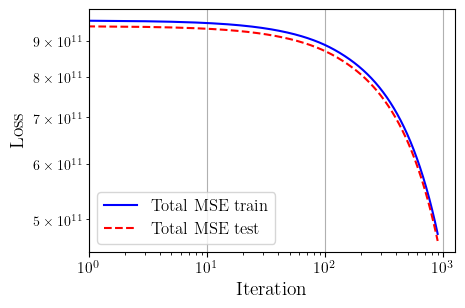

In [66]:
plt.figure(figsize=(width, height))
# plt.subplots_adjust(left=subplot_adjust_left, bottom=subplot_adjust_bottom) 

plt.plot(smooth_curve(train_total_loss_list), label='Total MSE train', color='blue', linestyle='-')
plt.plot(smooth_curve(test_total_loss_list), label='Total MSE test', color='red', linestyle='--')

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Loss', fontsize=label_fontsize)
# plt.title('Lineal homogeneous learning curve (MSE)', fontsize=title_fontsize)

plt.grid(True)
plt.legend(loc='lower left', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1) 

plt.show()

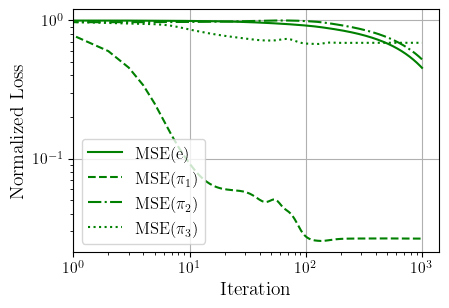

In [67]:
plt.figure(figsize=(width, height))
# plt.subplots_adjust(left=subplot_adjust_left, bottom=subplot_adjust_bottom) 

plt.plot(normalize_list((train_e_loss_list)), label=r'MSE(e) ', color='green', linestyle='-')
plt.plot(normalize_list((train_pi1_loss_list)), label=r'MSE($\pi_1$) ', color='green', linestyle='--')
plt.plot(normalize_list((train_pi2_loss_list)), label=r'MSE($\pi_2$) ', color='green', linestyle='-.')
plt.plot(normalize_list((train_pi3_loss_list)), label=r'MSE($\pi_3$) ', color='green', linestyle=':')

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Normalized Loss', fontsize=label_fontsize)
# plt.title('Lineal homogeneous normalized learning curves', fontsize=s)

plt.grid(True)
plt.legend(loc='lower left', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1) 

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'penalties_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

In [68]:
def relative_error_stats(validation, prediction, dx=dx, dy=dy):

    validation = validation.numpy()
    prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

    minimo = np.min(prediction_error)
    maximo = np.max(prediction_error)
    primer_cuartil = np.percentile(prediction_error, 25)
    mediana = np.percentile(prediction_error, 50)
    tercer_cuartil = np.percentile(prediction_error, 75)

    # Imprimir los resultados
    print(f"Mínimo: {minimo:.2e}")
    print(f"Primer cuartil (Q1): {primer_cuartil:.2e}")
    print(f"Mediana (Q2): {mediana:.2e}")
    print(f"Tercer cuartil (Q3): {tercer_cuartil:.2e}")
    print(f"Máximo: {maximo:.2e}")


def relative_error_return_Q(validation, prediction, dx=dx, dy=dy):

    validation = validation.numpy()
    prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx)/
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))
    
    tercer_cuartil = np.percentile(prediction_error, 75)

    Q_bool = prediction_error <= tercer_cuartil

    return Q_bool

In [69]:
fft_pred, y_pred, K_pred = model(X_val)

y_pred = TensOps(y_pred, space_dimension=2, contravariance=0, covariance=0)
K_pred = TensOps(K_pred, space_dimension=2, contravariance=0, covariance=0)

### Solution $u(x,y)$

In [70]:
u_validation = y_val.values.detach()
u_prediction = y_pred.values.detach()

relative_error_stats(u_validation, u_prediction)

Mínimo: 3.36e-01
Primer cuartil (Q1): 6.18e-01
Mediana (Q2): 6.65e-01
Tercer cuartil (Q3): 6.98e-01
Máximo: 8.99e-01


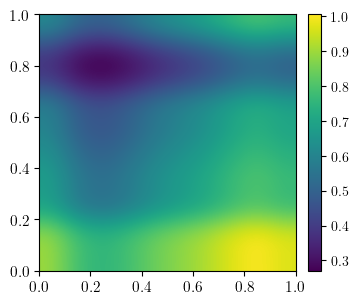

In [71]:
plt.figure(figsize=(height*1.2, height))

u_diff = torch.mean(torch.abs(u_prediction - u_validation), axis=0).squeeze()
plt.imshow(u_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Obtener los ticks generados automáticamente
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.000005)
cbar.set_ticks(new_ticks[1:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'solution_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

### Solution $u_m(x, y)$

In [72]:
um_validation = zo.Mx(zo.My(y_val)).values.detach()
um_prediction = zo.Mx(zo.My(y_pred)).values.detach()

relative_error_stats(um_validation, um_prediction)

Mínimo: 2.58e-01
Primer cuartil (Q1): 5.92e-01
Mediana (Q2): 6.46e-01
Tercer cuartil (Q3): 6.80e-01
Máximo: 8.74e-01


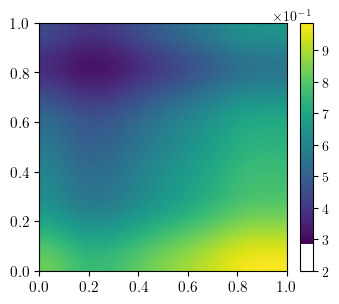

In [73]:
plt.figure(figsize=(height*1.2, height))

um_diff = torch.mean(torch.abs(um_prediction - um_validation), axis=0).squeeze()
plt.imshow(um_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Obtener los ticks generados automáticamente
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.0000005)
cbar.set_ticks(new_ticks[:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

plt.show()

### Diffusivity $K(u) = u(1-u)$

In [74]:
K_validation = zo.My(zo.Mx(K_val)).values.detach()
K_prediction = K_pred.values.detach()

relative_error_stats(K_validation, K_prediction)

Mínimo: 1.05e+00
Primer cuartil (Q1): 1.24e+00
Mediana (Q2): 1.45e+00
Tercer cuartil (Q3): 1.72e+00
Máximo: 9.74e+00


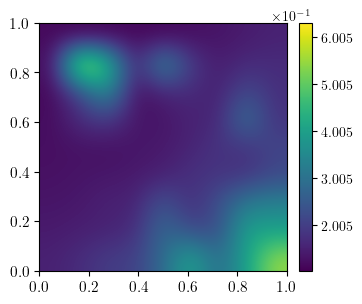

In [75]:
plt.figure(figsize=(height*1.2, height))

K_diff = torch.mean(torch.abs(K_prediction - K_validation), axis=0).squeeze()
plt.imshow(K_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Obtener los ticks generados automáticamente
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.0005)
cbar.set_ticks(new_ticks[1:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'diffusivity_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

### Flux $q_x(x, y)$

In [76]:
qx_validation = zo.Mx(zo.My(TensOps(torch.Tensor(dataset['qx_val']).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0))).values.detach()
qx_prediction = azo.scalar_product(K_pred, zo.Dx(y_pred, D)).values.detach()

relative_error_stats(qx_validation, qx_prediction)

Mínimo: 1.03e+00
Primer cuartil (Q1): 1.23e+00
Mediana (Q2): 1.52e+00
Tercer cuartil (Q3): 2.86e+00
Máximo: 5.63e+03


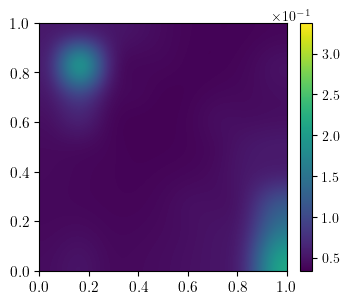

In [77]:
plt.figure(figsize=(height*1.2, height))

qx_diff = torch.mean(torch.abs(qx_prediction - qx_validation), axis=0).squeeze()
plt.imshow(qx_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Obtener los ticks generados automáticamente
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.00005)
cbar.set_ticks(new_ticks[1:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'qx_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

### Flux $q_y(x, y)$

In [78]:
qy_validation = zo.Mx(zo.My(TensOps(torch.Tensor(dataset['qy_val']).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0))).values.detach()
qy_prediction = azo.scalar_product(K_pred, zo.Dy(y_pred, D)).values.detach()

relative_error_stats(qy_validation, qy_prediction)

Mínimo: 1.10e+00
Primer cuartil (Q1): 1.69e+00
Mediana (Q2): 2.72e+00
Tercer cuartil (Q3): 5.97e+00
Máximo: 4.96e+03


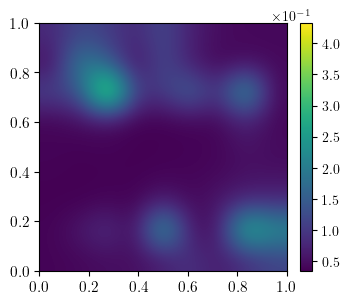

In [79]:
plt.figure(figsize=(height*1.2, height))

qy_diff = torch.mean(torch.abs(qy_prediction - qy_validation), axis=0).squeeze()
plt.imshow(qy_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Obtener los ticks generados automáticamente
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.00005)
cbar.set_ticks(new_ticks[1:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'qy_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

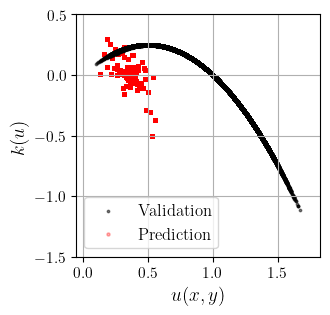

In [80]:
width = cm_to_in(12)  # ancho de la imagen
height = cm_to_in(8) # alto de la imagen

plt.figure(figsize=(height, height))
plt.scatter(um_prediction.flatten(), K_prediction.flatten(), label='Prediction', color='red', s=5, alpha=0.3)
plt.scatter(um_validation.flatten(), K_validation.flatten(), label='Validation', color='black', s=3, alpha=0.5)

plt.xlabel('$u(x, y)$', fontsize=label_fontsize)
plt.ylabel('$k(u)$', fontsize=label_fontsize)
# plt.title('Lineal homogeneous normalized learning curves', fontsize=s)

plt.grid(True)
# Obtener la leyenda actual y cambiar el orden
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]  # Cambiar el orden de las etiquetas aquí (Validation primero, Prediction segundo)
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='lower left', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)


min = torch.min(um_validation.flatten()) - 0.1*(torch.max(um_validation.flatten() - torch.min(um_validation.flatten())))
max = torch.max(um_validation.flatten()) + 0.1*(torch.max(um_validation.flatten() - torch.min(um_validation.flatten())))

plt.xlim(min, max)
plt.ylim(-1.5, 0.5)

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'ku_vs_u_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

In [81]:
er = np.sum(np.trapz(np.trapz(K_prediction.squeeze() - K_validation.squeeze(), dx=dx), dx=dy))**2/np.sum(np.trapz(np.trapz(K_validation.squeeze(), dx=dx), dx=dy))**2

print(f"er(K): {er:.2e}")

er(K): 5.27e-01


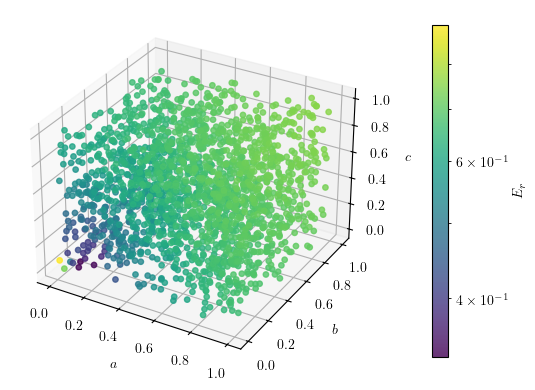

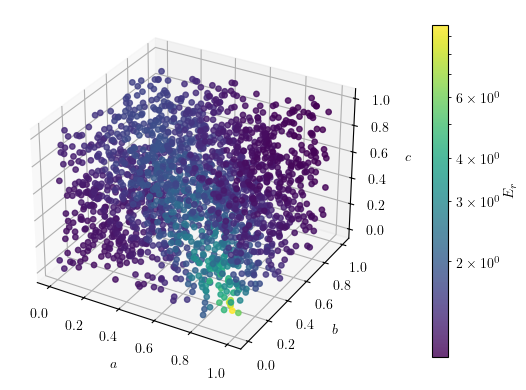

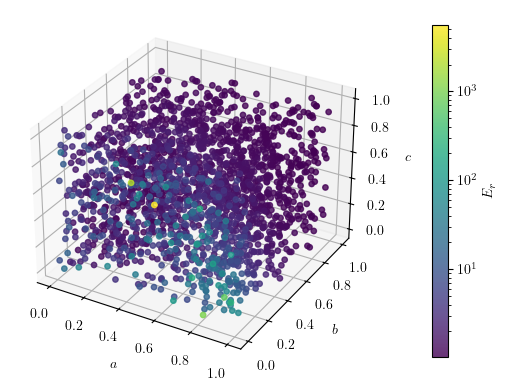

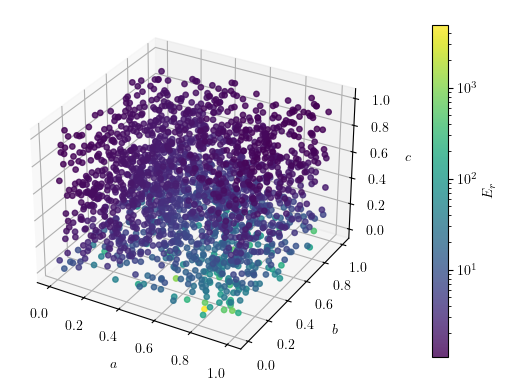

In [82]:
def relative_error(validation, prediction, dx=dx, dy=dy):
    return np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx)/
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

def calculate_error(validation_data, predicted_data):
    numerator = np.trapz(np.trapz((validation_data - predicted_data)**2))
    denominator = np.trapz(np.trapz((validation_data)**2))

    if np.all(denominator == 0):
        result = np.sqrt(numerator)
    else:
        result = np.sqrt(numerator/denominator)
    return result

E_K = relative_error(K_validation, K_prediction)
E_solution = relative_error(u_validation, u_prediction)
E_qx = relative_error(qx_validation, qx_prediction)
E_qy = relative_error(qy_validation, qy_prediction)

a = dataset['g1_val']
b = dataset['g2_val']
c = dataset['g3_val']

def plot_error(a, b, c, error, variable):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(a, b, c, c=error, cmap='viridis', s=15, alpha=0.8, norm=mcolors.LogNorm())
    cbar = plt.colorbar(sc, pad=0.12, shrink=0.9)
    cbar.set_label('$E_r$')

    ax.set_xlabel('$a$')
    ax.set_ylabel('$b$')
    ax.set_zlabel('$c$')

    # plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'{variable}_val_error_parameters_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
    plt.show()

plot_error(a=a, b=b, c=c, error=E_solution, variable='solution')
plot_error(a=a, b=b, c=c, error=E_K, variable='K')
plot_error(a=a, b=b, c=c, error=E_qx, variable='qx')
plot_error(a=a, b=b, c=c, error=E_qy, variable='qy')